In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.predic import prediction
from Proteus.proteus.predic import predlib
from Proteus.proteus.predic import betacluster as bc
from Proteus.proteus.visu import matrix as visu
from Proteus.proteus.predic import fselection as fselect
import pandas as pd
import scipy.io
from os import listdir
import cPickle as pickle
from sklearn import cross_validation

from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

from sklearn.cross_validation import StratifiedKFold
from sklearn import preprocessing

//anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.weave` is deprecated, use `weave` instead!
  warnings.warn(depdoc, DeprecationWarning)


# Load the data

In [3]:
# load the model
demograph = pd.read_csv('/Users/christian/git/predicad/cobre/cobre_model_group.csv', index_col=0)
demograph = demograph.sort()

root_path = '/Users/christian/cobre/voxel_ts/'
list_files = listdir(root_path)

#data = scipy.io.loadmat('/Users/christian/cobre/cobre_vols_all.mat')
conn = pd.read_pickle('/Users/christian/cobre/cobre_connectivity_all.pkl')
#conn = pickle.load(open("/Users/christian/cobre/cobre_connectivity_all.pkl", "rb") )


In [223]:
demograph = pd.read_csv('/Users/christian/git/predicad/cobre/cobre_model_group.csv', index_col=0)
demograph = demograph.sort()

real_data = pd.read_csv('/Users/christian/git/predicad/cobre/COBRE_phenotypic_data.csv', index_col=0)
real_data = real_data.sort()
real_data['Subject Type']=='Control' 

#print real_data['Subject Type']=='Patient'

data_idx = demograph['sz'].index.values
ref_idx = real_data.index.values

#print data_idx.shape
#print ref_idx.shape
#print data_idx

print data_idx.shape
for i in range(0,data_idx.shape[0]):
    print data_idx[i][-5:]
    
    try:
        tmp_val = real_data.loc[int(data_idx[i][-5:]),['Subject Type']].values[0]
        print tmp_val
        if 'Patient' in tmp_val:
            if not (1 == demograph.loc[data_idx[i],['sz']].values[0]):
                print "Error label subject: ", data_idx[i]
        elif 'Control' in tmp_val:
            if not (0 == demograph.loc[data_idx[i],['sz']].values[0]):
                print "Error label subject: ", data_idx[i]
    except:
        print "Missing subject: ", data_idx[i]



    #matching = [s for s in ref_idx if data_idx[i][9:] in s]
#print real_data.loc[int(data_idx[i][-5:]),['Subject Type']].values[0] == 'Patient'
                    
#print data_idx[1][9:]
#print ref_idx[14] == int(data_idx[1][-5:])

(146,)
40013
Control
40014
Control
40017
Control
40018
Control
40019
Control
40020
Control
40023
Control
40024
Control
40026
Control
40027
Control
40030
Control
40031
Control
40033
Control
40035
Control
40036
Control
40038
Control
40043
Control
40045
Control
40048
Control
40050
Control
40051
Control
40052
Control
40053
Control
40054
Control
40055
Control
40056
Control
40057
Control
40058
Control
40061
Control
40062
Control
40063
Control
40065
Control
40066
Control
40067
Control
40068
Control
40069
Control
40074
Control
40076
Control
40086
Control
40087
Control
40090
Control
40091
Control
40093
Control
40095
Control
40102
Control
40104
Control
40107
Control
40111
Control
40113
Control
40114
Control
40115
Control
40116
Control
40118
Control
40119
Control
40120
Control
40121
Control
40123
Control
40124
Control
40125
Control
40127
Control
40128
Control
40129
Control
40130
Control
40131
Control
40134
Control
40135
Control
40136
Control
40138
Control
40139
Control
40140
Control
40141
Control

In [214]:
data['vols'].shape

(53, 64, 52, 139)

In [237]:
import h5py
# get the multiscale connectivity matrix for each subject
ms_data = []
for i, subj_name in enumerate(demograph.index.get_values()):
    print '/Users/christian/cobre/interscale_corrmatrix/corrmatrix_' + subj_name + '.mat'
    f = h5py.File('/Users/christian/cobre/interscale_corrmatrix/corrmatrix_' + subj_name + '.mat')
    d_tmp = np.array(f['R'])
    if len(ms_data) > 0:
        ms_data = np.vstack((ms_data,ts.mat2vec(d_tmp)))
    else:
        ms_data = ts.mat2vec(d_tmp)
    
    


/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040013.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040014.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040017.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040018.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040019.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040020.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040023.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040024.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040026.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040027.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040030.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040031.mat
/Users/christian/cobre/interscale_corrmatrix/corrmatrix_contxxx0040033.mat
/Users/christian/cobre/in

In [61]:
#Test the max margin 
reload(fselect)

def near(X,xi):
    #print(X)
    # nearest point to x in P with the same label
    if X.shape[0]>1:
        #print(X)
        idx = norm(X - xi).argmin()
        #print(idx)
        return X[idx,:]
    else:
        return X

def norm(x,order=2):
    if x.ndim > 1:
        return np.linalg.norm(x, ord=order, axis=1)
    else:
        return x

def excludeIdx(idx,X,Y):
    return  X[idx,:], np.delete(X,idx,axis=0), np.delete(Y,idx,axis=0)

def normw(W,z):
    return norm(W*z,2)

def margin(idx,X,Y,W,label_hit = 1,label_miss = -1):
    xi,Xp,Yp = excludeIdx(idx,X,Y)
    nearhit = near(Xp[Yp == label_hit,:],xi[idx])
    print nearhit
    nearmiss = near(Xp[Yp == label_miss,:],xi[idx])
    print nearmiss
    print xi
    return 1./2*( normw(W,xi-nearmiss) - normw(W,xi-nearhit) )

def gflip(x,y):
    """
    Greedy Feature Flip (G-flip)
    Gilad-Bachrach (2004)
    """
    F = []; #Initialize the set of chosen features to the empty
    # for t = 1,2,...
    #for t in range(5):
        # pick a random permutation s of {1 . . . N} 
        #for i in s:
            # for each value i in s 



X = np.array([[1.1, 2.1, 3.1, -1.0],  # first sample
        [30.2, 32.2, 33.2, 1.1],   # second sample
        [1.3, 2.3, 3.3, -1.1], # third sample
        [5.3, 5.3, 3.5, 1.0]]) # third sample  
Y = np.array([1, -1, 1, -1])     # classes
#nearhit(X[0,:],np.delete(X,0,axis=0),np.delete(Y,0,axis=0))
W = np.ones(X.shape[1])
print(margin(0,X,Y,W,1,-1))

#xi,Xp,Yp = excludeIdx(0,X,Y)
#print Xp[Yp == 1,:]

#near(Xp[Yp == -1,:],xi[0])



[[ 1.3  2.3  3.3 -1.1]]
[ 5.3  5.3  3.5  1. ]
[ 1.1  2.1  3.1 -1. ]
[-2.28027756 -1.78027756 -0.38027756 -1.18027756]


# Prediction model

In [152]:


# selecte a network scale and extract the features
x = conn[4].loc[demograph.index.values].values
y = demograph['sz'].values

# remove intra matrix mean and var
x = ts.normalize_data(x)

x.shape, y.shape

((146, 2016), (146,))

## Preprocessing

In [7]:


#scaler = preprocessing.StandardScaler().fit(x)
#x_scaled = scaler.transform(x)
x_scaled = x
encoder = preprocessing.LabelEncoder()
encoder.fit(y)


LabelEncoder()

## Feature selection

In [103]:

reload(fselect)
w = fselect.irelief_cross(x_scaled,encoder.transform(y),10)
#candidat_f = fselect.nBest(w,108)
#avg_score = w.mean(axis=0)


iRelief, sample size:  (130, 2016)
iRelief, sample size:  (130, 2016)
iRelief, sample size:  (131, 2016)
iRelief, sample size:  (131, 2016)
iRelief, sample size:  (132, 2016)
iRelief, sample size:  (132, 2016)
iRelief, sample size:  (132, 2016)
iRelief, sample size:  (132, 2016)
iRelief, sample size:  (132, 2016)
iRelief, sample size:  (132, 2016)


In [104]:
reload(fselect)
#print np.argsort(w.mean(axis=0))
candidat_f = fselect.nBest(w,108)


[1625  389 1447 ..., 1677 1690 1062]


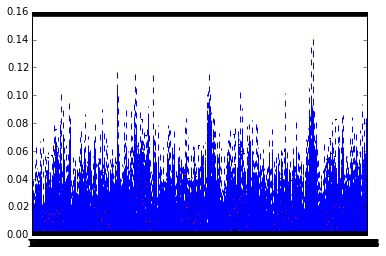

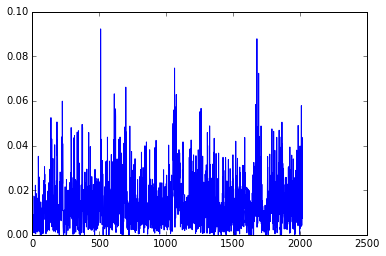

In [83]:

plt.boxplot(w)
plt.figure()
plt.plot(avg_score)


[2000 1974  809  656 1802 1467 1857 1770  514  589 1064 1271 1825 2013  188
  716 1095  227  595 1702 1211 1213  633  662 1982 1789 1391  608 1025 1519
 1532 1918 1849 1923  648 1372  590 1051 1985 2002 1689 2009  703 1239 1673
  523  224  310  225 1783  185  619 1100 1324 1053  372 1999 1693 1811  315
  134  344  681 1049 1800  167  610 1674  291 1186  815 1708  622 1075 1703
 1067 1864 1072  621  186  375  645  511 1050 1260  657  690 1667  184 1069
  698 1068 1252 1063 1055  612 1949 1054 1672  510 1680 1681 2011 1690 1668
 1687 1677 1062] Sum scores: 4.50491703856 Nfeatures: 108
[  45  139  145  167  184  185  186  188  222  224  225  227  290  291  310
  315  335  344  372  375  421  433  510  511  514  561  590  610  612  619
  620  621  622  645  648  655  657  662  666  681  690  692  698  703  728
  741  815  841  852  876  916  924 1018 1049 1050 1051 1053 1054 1055 1057
 1062 1063 1064 1067 1068 1069 1072 1075 1085 1095 1100 1125 1126 1174 1179
 1186 1204 1222 1239 1252 1260

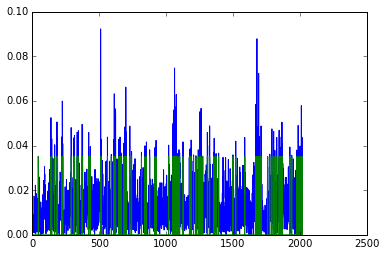

In [84]:
# the threshold
#t_val = 0.035 % with scale 4 78% accu
t_val=0.035
plt.plot(avg_score)
plt.plot(0.035*(avg_score>t_val))

#candidat_f = np.where(avg_score>t_val)[0]
print candidat_f, "Sum scores:", (avg_score[candidat_f]).sum(), "Nfeatures:",len(avg_score[candidat_f])

candidat_f_t = np.where(avg_score>t_val)[0]
print candidat_f_t, "Sum scores:", (avg_score[candidat_f_t]).sum(), "Nfeatures:",len(avg_score[candidat_f_t])

"""
2000 1974  809  656 1802 1467 1857 1770  514  589 1064 1271 1825 2013  188
  716 1095  227  595 1702 1211 1213  633  662 1982 1789 1391  608 1025 1519
 1532 1918 1849 1923  648 1372  590 1051 1985 2002 1689 2009  703 1239 1673
  523  224  310  225 1783  185  619 1100 1324 1053  372 1999 1693 1811  315
  134  344  681 1049 1800  167  610 1674  291 1186  815 1708  622 1075 1703
 1067 1864 1072  621  186  375  645  511 1050 1260  657  690 1667  184 1069
  698 1068 1252 1063 1055  612 1949 1054 1672  510 1680 1681 2011 1690 1668
 1687 1677 1062
 """

## Grid search for hyper parameters

In [85]:


##############################################################################
# Train classifier
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = 10.0 ** np.arange(-7,5)
gamma_range = 10.0 ** np.arange(-5, 3)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)
grid = GridSearchCV(SVC(kernel='rbf', class_weight='auto'), param_grid=param_grid, cv=cv)
grid.fit(x_scaled[:,candidat_f], encoder.transform(y))

print("The best classifier is: ", grid.best_estimator_)
param_grid

('The best classifier is: ', SVC(C=10.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.01, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False))


{'C': array([  1.00000000e-07,   1.00000000e-06,   1.00000000e-05,
          1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
          1.00000000e-01,   1.00000000e+00,   1.00000000e+01,
          1.00000000e+02,   1.00000000e+03,   1.00000000e+04]),
 'gamma': array([  1.00000000e-05,   1.00000000e-04,   1.00000000e-03,
          1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
          1.00000000e+01,   1.00000000e+02])}

## Train model and evaluate

Train: 1.0
Test : 0.8125
Prediction : [0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train: 1.0
Test : 0.8125
Prediction : [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train: 1.0
Test : 0.666666666667
Prediction : [0 0 0 0 1 0 1 0 1 0 0 1 1 0 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train: 1.0
Test : 0.8
Prediction : [1 1 0 0 0 0 0 0 1 1 1 1 1 0 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train: 1.0
Test : 0.785714285714
Prediction : [0 0 0 1 0 0 1 1 1 1 1 1 1 0]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train: 1.0
Test : 0.785714285714
Prediction : [0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train: 1.0
Test : 0.857142857143
Prediction : [1 0 0 0 0 1 0 1 1 1 1 1 1 1]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train: 1.0
Test : 0.642857142857
Prediction : [1 0 0 0 0 0 1 1 0 1 0 1 0 1]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train: 1.0
Test : 0.785714285714
Prediction : [0 0 

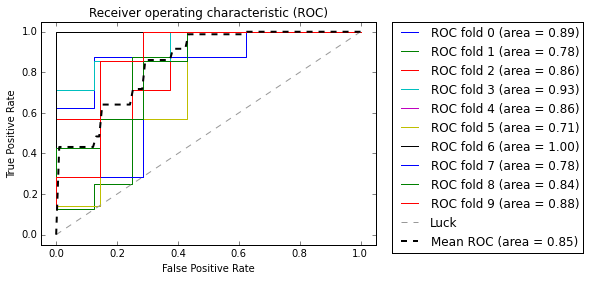

In [80]:
#from sklearn.lda import LDA
from sklearn.metrics import roc_curve, auc
from scipy import interp

clf = grid.best_estimator_
skf = cv
if len(candidat_f)>0:
    select_x = x_scaled[:,candidat_f]
else:
    select_x = x_scaled

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(skf):
    #print("%s %s" % (train, test))
    #print x_scaled[test]
    #print y[train], np.sum(y[train]==1),np.sum(y[train]==2)
    #print(clf.get_params)
    #clf = LDA()
    clf.probability = True
    clf.fit(select_x[train],encoder.transform(y[train]))
    print "Train:",clf.score(select_x[train],encoder.transform(y[train]))
    print "Test :",clf.score(select_x[test],encoder.transform(y[test]))
    print "Prediction :",clf.predict(select_x[test])
    print "Real Labels:",encoder.transform(y[test])
    
    probas_ = clf.predict_proba(select_x[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)


In [149]:
from sklearn import svm
from sklearn import cross_validation

clf = grid.best_estimator_
#clf.score(x_scaled[test,:],y[test])
#cv = StratifiedKFold(y=y, n_folds=10)
scores = cross_validation.cross_val_score(clf, select_x, y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.77 (+/- 0.13)


# Calibration model

(146, 2016)
Train: 1.0
Test : 0.5625
Prediction : [0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
(146, 2016)
Train: 1.0
Test : 0.5625
Prediction : [1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
(146, 2016)
Train: 1.0
Test : 0.666666666667
Prediction : [0 0 0 0 1 1 0 0 1 0 1 0 1 0 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(146, 2016)
Train: 1.0
Test : 0.733333333333
Prediction : [0 0 1 0 0 1 0 0 1 0 1 0 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(146, 2016)
Train: 1.0
Test : 0.714285714286
Prediction : [0 0 0 0 0 0 1 1 0 1 1 0 1 0]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(146, 2016)
Train: 1.0
Test : 0.571428571429
Prediction : [0 0 1 0 1 1 1 1 1 1 0 1 1 0]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(146, 2016)
Train: 1.0
Test : 0.714285714286
Prediction : [1 0 0 0 0 1 1 1 1 0 1 1 1 1]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(146, 2016)
Train: 1.0
Test : 0.571428571429
Prediction : [1 1 0 0 0 0 1 1 

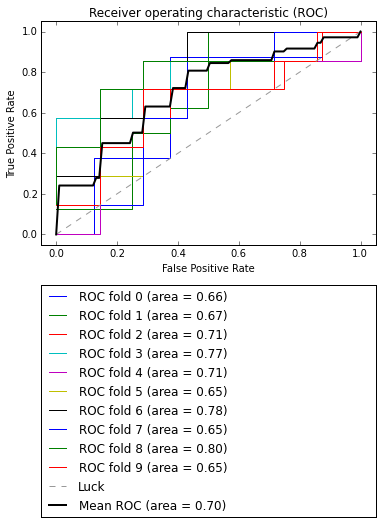

mean 0.645357142857 std 0.0686404249441


In [167]:
from sklearn.lda import LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
reload(fselect)
reload(plib)

# feature selection
from sklearn.decomposition import PCA, FactorAnalysis

# selecte a network scale and extract the features
x = conn[4].loc[demograph.index.values].values
y = demograph['sz'].values

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

# remove intra matrix mean and var
x = ts.normalize_data(x)

skf = StratifiedKFold(y=encoder.transform(y), n_folds=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

total_test_score=[]

for i, (train, test) in enumerate(skf):
    
    candidat_f = []
    #w = fselect.irelief_cross(x_scaled[train,:],encoder.transform(y[train]),10)
    #candidat_f = fselect.nBest(w,90)

    
    select_x = x.copy()
    
    clf = SVC(kernel='linear', class_weight='auto', C=1.)
    
    clf.probability = True
    #clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
    print select_x.shape
    
    
    clf.fit(select_x[train,:],encoder.transform(y[train]))
    print "Train:",clf.score(select_x[train,:],encoder.transform(y[train]))
    print "Test :",clf.score(select_x[test,:],encoder.transform(y[test]))
    print "Prediction :",clf.predict(select_x[test,:])
    print "Real Labels:",encoder.transform(y[test])
    
    total_test_score.append(clf.score(select_x[test,:],encoder.transform(y[test])))
    
    probas_ = clf.predict_proba(select_x[test,:])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

total_test_score
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(0., 1.02, 1., -1.202), loc=1,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)

print 'mean', np.mean(total_test_score), 'std',  np.std(total_test_score)


# Confound regression

(146, 2016)
Train: 0.9
Test : 0.6875
Prediction : [0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[53 52]
(105, 2016)
(146, 2016)
Train: 0.930769230769
Test : 0.6875
Prediction : [0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[54 54]
(108, 2016)
(146, 2016)
Train: 0.931297709924
Test : 0.6
Prediction : [0 0 0 0 1 0 0 1 0 0 0 1 1 0 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
[52 54]
(106, 2016)
(146, 2016)
Train: 0.908396946565
Test : 0.8
Prediction : [1 1 0 0 0 0 0 0 1 1 1 0 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
[55 56]
(111, 2016)
(146, 2016)
Train: 0.931818181818
Test : 0.785714285714
Prediction : [0 0 0 0 0 0 1 1 0 1 1 1 1 0]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
[54 52]
(106, 2016)
(146, 2016)
Train: 0.924242424242
Test : 0.571428571429
Prediction : [0 0 0 0 1 0 0 1 0 1 0 0 0 0]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
[54 52]
(106, 2016)
(146, 2016)
Train: 0.909090909091
Test : 0.7857142857

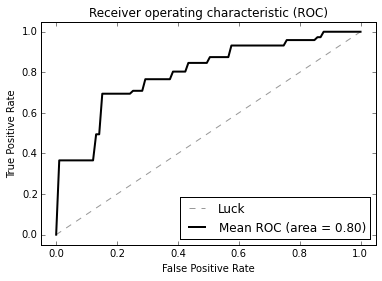

mean 0.698928571429 std 0.0869523679132


In [166]:
from sklearn.lda import LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
from sklearn.utils import shuffle
reload(fselect)
reload(plib)
reload(prediction)

# feature selection
from sklearn.decomposition import PCA, FactorAnalysis

# selecte a network scale and extract the features
x = conn[4].loc[demograph.index.values].values
y = demograph['sz'].values
confounds = preprocessing.scale(demograph[['age','sex']].values)
#x = preprocessing.scale(x)
#x, y, confounds = shuffle(x, y, confounds, random_state=1)

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

# remove intra matrix mean and var
x = ts.normalize_data(x)
#cv = cross_validation.KFold(len(y),n_folds=10)
cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)
#cv = cross_validation.LeaveOneOut(data_all.shape[0])

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

total_test_score=[]

for i, (train, test) in enumerate(cv):
    
    select_x = x.copy()
    
    crm = prediction.ConfoundsRm(confounds[train,:],select_x[train,:])
    
    clf = SVC(kernel='linear', class_weight='auto', C=.01)
    #clf = NuSVC(kernel='linear', nu=.01)
    #clf = LogisticRegression(penalty='l2',C=100.)
    #clf = LDA(solver='lsqr', shrinkage='auto')
    #clf = LDA()

    clf.probability = True
    #clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
    print select_x.shape
    
    
    clf.fit(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
    #print('nSupport: ',clf.n_support_)
    print "Train:",clf.score(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
    print "Test :",clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test]))
    print "Prediction :",clf.predict(crm.transform(confounds[test,:],select_x[test,:]))
    print "Real Labels:",encoder.transform(y[test])
    
    total_test_score.append( clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test])))
    
    probas_ = clf.predict_proba(crm.transform(confounds[test,:],select_x[test,:]))
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    #print clf.support_
    print clf.n_support_
    print clf.support_vectors_.shape
    

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

total_test_score
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc="lower right")
plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)

print 'mean', np.mean(total_test_score), 'std',  np.std(total_test_score)


## bar graph optimal scale

(9,)
mean 0.669880952381


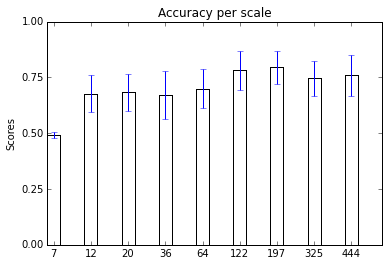

In [87]:
from sklearn.lda import LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
from sklearn.utils import shuffle
reload(fselect)
reload(plib)
reload(prediction)

# feature selection
from sklearn.decomposition import PCA, FactorAnalysis


scales = [7,12,20,36,64,122,197,325,444]
test_score=np.empty((10,len(scales)))


for s in range(0,len(scales)):
    # selecte a network scale and extract the features
    x = conn[s].loc[demograph.index.values].values
    y = demograph['sz'].values
    confounds = preprocessing.scale(demograph[['age','sex']].values)
    #x = preprocessing.scale(x)
    #x, y, confounds = shuffle(x, y, confounds, random_state=1)

    encoder = preprocessing.LabelEncoder()
    encoder.fit(y)

    # remove intra matrix mean and var
    x = ts.normalize_data(x)

    cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)
    #cv = cross_validation.LeaveOneOut(data_all.shape[0])

    for i, (train, test) in enumerate(cv):


        select_x = x.copy()
        crm = prediction.ConfoundsRm(confounds[train,:],select_x[train,:])

        clf = SVC(kernel='linear', class_weight='auto', C=1.)

        #clf.probability = True
        #clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
        #print select_x.shape

        clf.fit(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
        #print('nSupport: ',clf.n_support_)
        #print "Train:",clf.score(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
        #print "Test :",clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test]))
        #print "Prediction :",clf.predict(crm.transform(confounds[test,:],select_x[test,:]))
        #print "Real Labels:",encoder.transform(y[test])

        test_score[i,s] = clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test]))

    

scalesMeans = (test_score.mean(axis=0))
scalesStd  = (test_score.std(axis=0))
ind = np.arange(len(scales))  # the x locations for the groups
width = 0.35       # the width of the bars
#fig, ax = plt.subplots()
#rects1 = ax.bar(ind, scalesMeans, width, color='b', yerr=scalesStd)
p1 = plt.bar(ind, scalesMeans,   width, color='w', yerr=scalesStd)
# add some text for labels, title and axes ticks
plt.ylabel('Scores')
plt.title('Accuracy per scale')
plt.xticks(ind+width/2., scales )
plt.yticks(np.arange(0,1.1,0.1))

print 'mean', np.mean(test_score,axis=0)/float(len(cv))


([<matplotlib.axis.YTick at 0x11030fc10>,
 <a list of 11 Text yticklabel objects>)

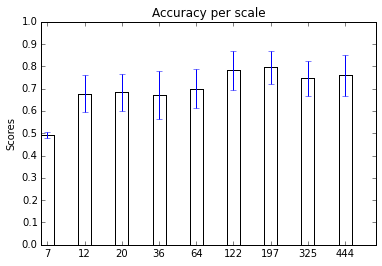

In [89]:
scalesMeans = (test_score.mean(axis=0))
scalesStd  = (test_score.std(axis=0))
ind = np.arange(len(scales))  # the x locations for the groups
width = 0.35       # the width of the bars
#fig, ax = plt.subplots()
#rects1 = ax.bar(ind, scalesMeans, width, color='b', yerr=scalesStd)
p1 = plt.bar(ind, scalesMeans,   width, color='w', yerr=scalesStd)
# add some text for labels, title and axes ticks
plt.ylabel('Scores')
plt.title('Accuracy per scale')
plt.xticks(ind+width/2., scales )
plt.yticks(np.arange(0,1.1,0.1))


### leave one out

In [50]:
from sklearn.lda import LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
from sklearn.utils import shuffle
reload(fselect)
reload(plib)
reload(prediction)

# feature selection
from sklearn.decomposition import PCA, FactorAnalysis

# selecte a network scale and extract the features
x = conn[6].loc[demograph.index.values].values
y = demograph['sz'].values
confounds = preprocessing.scale(demograph[['age','sex']].values)
#x = preprocessing.scale(x)
#x, y, confounds = shuffle(x, y, confounds, random_state=1)

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

# remove intra matrix mean and var
x = ts.normalize_data(x)

#cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)
cv = cross_validation.LeaveOneOut(len(y))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

total_test_score=0

for i, (train, test) in enumerate(cv):
    
    candidat_f = []
    
    #w = fselect.irelief_cross(x_scaled[train,:],encoder.transform(y[train]),10)
    #candidat_f = fselect.nBest(w,90)

    
    if len(candidat_f)>0:
        select_x = x[:,candidat_f]
    else:
        select_x = x.copy()
    
    crm = prediction.ConfoundsRm(confounds[train,:],select_x[train,:])
    
    clf = SVC(kernel='linear', class_weight='auto', C=.01)
    

    clf.probability = True
    #clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
    print select_x.shape
    
    clf.fit(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
    #print('nSupport: ',clf.n_support_)
    print "Train:",clf.score(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
    print "Test :",clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test]))
    print "Prediction :",clf.predict(crm.transform(confounds[test,:],select_x[test,:]))
    print "Real Labels:",encoder.transform(y[test])
    
    total_test_score += clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test]))
    '''
    probas_ = clf.predict_proba(crm.transform(confounds[test,:],select_x[test,:]))
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    '''
'''
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

total_test_score
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)
'''
print 'mean', np.mean(total_test_score)/float(len(cv))


(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 0.0
Prediction : [1]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 0.0
Prediction : [1]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 0.0
Prediction : [1]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 0.0
Prediction : [1]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0
Prediction : [0]
Real Labels: [0]
(146, 19306)
Train: 1.0
Test : 1.0

# Feature selection max margin

iRelief ...
(7531,)
Running grid search ...
New best:  0.807692307692
(5946,)
Running grid search ...
New best:  0.815384615385
(4655,)
Running grid search ...
New best:  0.830769230769
(3634,)
Running grid search ...
New best:  0.838461538462
(2796,)
Running grid search ...
(2133,)
Running grid search ...
(1623,)
Running grid search ...
(1215,)
Running grid search ...
(894,)
Running grid search ...
(680,)
Running grid search ...
New best:  0.892307692308
(514,)
Running grid search ...
(146, 19306)
Train: 1.0
Test : 0.6875
Prediction : [0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
iRelief ...
(7196,)
Running grid search ...
New best:  0.792307692308
(5841,)
Running grid search ...
New best:  0.823076923077
(4679,)
Running grid search ...
(3719,)
Running grid search ...
New best:  0.838461538462
(2916,)
Running grid search ...
New best:  0.853846153846
(2273,)
Running grid search ...
(1744,)
Running grid search ...
(1290,)
Running grid search ...
(982,

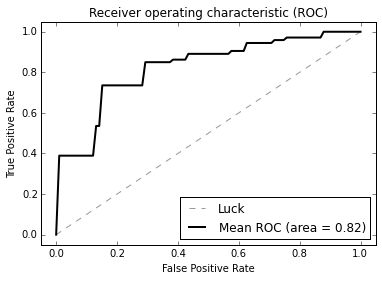

mean 0.739464285714 std 0.0741285587721


In [159]:
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
from sklearn.utils import shuffle
reload(fselect)
reload(plib)
reload(prediction)

# feature selection
from sklearn.decomposition import PCA, FactorAnalysis

# selecte a network scale and extract the features
x = conn[6].loc[demograph.index.values].values
y = demograph['sz'].values
confounds = preprocessing.scale(demograph[['age','sex']].values)
# remove intra matrix mean and var
x = ts.normalize_data(x)

#x, y, confounds = shuffle(x, y, confounds, random_state=0)
select_x = x

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

total_test_score=[]

for i, (train, test) in enumerate(cv):
    
    candidat_f = []
    
    crm = prediction.ConfoundsRm(confounds[train,:],select_x[train,:].copy())
    w = fselect.irelief_cross(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]),1)
    #candidat_f = fselect.nBest(w,90)
    
    
    clf,candidat_f,best_n,all_nfeatures,all_scores = prediction.get_opt_model_features_std(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]),w)
    
    clf.probability = True
    #clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
    print select_x.shape
    
    
    clf.fit(crm.transform(confounds[train,:],select_x[train,:])[:,candidat_f],encoder.transform(y[train]))
    #print('nSupport: ',clf.n_support_)
    print "Train:",clf.score(crm.transform(confounds[train,:],select_x[train,:])[:,candidat_f],encoder.transform(y[train]))
    print "Test :",clf.score(crm.transform(confounds[test,:],select_x[test,:])[:,candidat_f],encoder.transform(y[test]))
    print "Prediction :",clf.predict(crm.transform(confounds[test,:],select_x[test,:])[:,candidat_f])
    print "Real Labels:",encoder.transform(y[test])
    
    total_test_score.append(clf.score(crm.transform(confounds[test,:],select_x[test,:])[:,candidat_f],encoder.transform(y[test])))
    
    probas_ = clf.predict_proba(crm.transform(confounds[test,:],select_x[test,:])[:,candidat_f])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

total_test_score
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc="lower right")
plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)

print 'mean', np.mean(total_test_score), 'std',  np.std(total_test_score)


## Random feature selection

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
reload(fselect)
reload(plib)
reload(prediction)

# feature selection
from sklearn.decomposition import PCA, FactorAnalysis

# selecte a network scale and extract the features
x = conn[6].loc[demograph.index.values].values
y = demograph['sz'].values
confounds = preprocessing.scale(demograph[['age','sex']].values)

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

# remove intra matrix mean and var
x = ts.normalize_data(x)

cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

total_test_score=0

for i, (train, test) in enumerate(cv):
    
    candidat_f = []
    
    crm = prediction.ConfoundsRm(confounds[train,:],x[train,:].copy())
    w = fselect.irelief_cross(crm.transform(confounds[train,:],x[train,:]),encoder.transform(y[train]),1)
    #candidat_f = fselect.nBest(w,90)
    
    
    clf,candidat_f,best_n,all_nfeatures,all_scores = prediction.get_opt_model_features_std(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]),w)
    #clf = SVC(kernel='linear', class_weight='auto', C=.01)
    #clf = NuSVC(kernel='linear', nu=.01)
    #clf = LogisticRegression(penalty='l2',C=100.)
    #clf = LDA(solver='lsqr', shrinkage='auto')
    #clf = LDA()
    '''
    if len(candidat_f)>0:
        select_x = x[:,candidat_f].copy()
    else:
        select_x = x.copy()
    '''
    clf.probability = True
    #clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
    print select_x.shape
    
    #grid.fit(select_x[train,:], encoder.transform(y[train]))

    #print("The best classifier is: ", grid.best_estimator_)
    #param_grid
    #clf = grid.best_estimator_
    
    clf.fit(crm.transform(confounds[train,:],select_x[train,:])[:,candidat_f],encoder.transform(y[train]))
    #print('nSupport: ',clf.n_support_)
    print "Train:",clf.score(crm.transform(confounds[train,:],select_x[train,:])[:,candidat_f],encoder.transform(y[train]))
    print "Test :",clf.score(crm.transform(confounds[test,:],select_x[test,:])[:,candidat_f],encoder.transform(y[test]))
    print "Prediction :",clf.predict(crm.transform(confounds[test,:],select_x[test,:])[:,candidat_f])
    print "Real Labels:",encoder.transform(y[test])
    
    #plt.figure()
    #plt.plot(clf.support_vectors_)
    '''
    X_r2 = clf.transform(select_x)
    print X_r2.shape
    target_names = ['patient','control']
    plt.figure()
    for c, i, target_name in zip("rb", [0,1], target_names):
        plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
    plt.legend()
    plt.title('LDA')
    '''
    
    total_test_score += clf.score(crm.transform(confounds[test,:],select_x[test,:])[:,candidat_f],encoder.transform(y[test]))
    
    probas_ = clf.predict_proba(crm.transform(confounds[test,:],select_x[test,:])[:,candidat_f])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

total_test_score
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)

print 'mean', np.mean(total_test_score)/float(len(cv))


# RBF with 79%

Running grid search ...
(146, 19306)
Train: 1.0
Test : 0.6875
Prediction : [0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Running grid search ...
(146, 19306)
Train: 1.0
Test : 0.8125
Prediction : [1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Running grid search ...
(146, 19306)
Train: 0.992366412214
Test : 0.666666666667
Prediction : [0 0 0 0 1 0 0 1 1 0 0 1 1 0 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Running grid search ...
(146, 19306)
Train: 0.992366412214
Test : 0.866666666667
Prediction : [1 1 0 0 0 0 0 0 1 1 1 1 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Running grid search ...
(146, 19306)
Train: 1.0
Test : 0.857142857143
Prediction : [0 0 0 0 0 0 1 1 0 1 1 1 1 1]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Running grid search ...
(146, 19306)
Train: 1.0
Test : 0.714285714286
Prediction : [0 0 0 0 1 0 0 1 0 1 0 0 1 1]
Real Labels: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Running grid search ...
(146, 1930

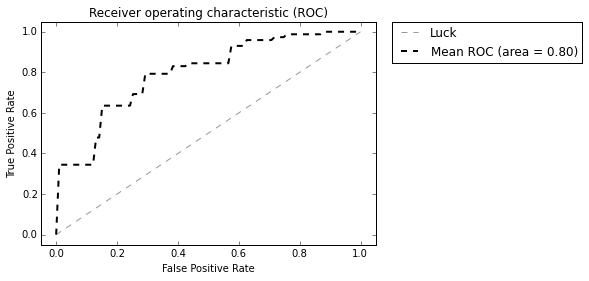

mean 0.74619047619 std 0.0875741506348


In [158]:
from sklearn.lda import LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
reload(fselect)
reload(plib)
reload(prediction)

# feature selection
from sklearn.decomposition import PCA, FactorAnalysis

# selecte a network scale and extract the features
x = conn[6].loc[demograph.index.values].values
y = demograph['sz'].values
confounds = preprocessing.scale(demograph[['age','sex']].values)

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

# remove intra matrix mean and var
x = ts.normalize_data(x)

cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

total_test_score=[]

for i, (train, test) in enumerate(cv):
    
    candidat_f = []
    
    #w = fselect.irelief_cross(x_scaled[train,:],encoder.transform(y[train]),10)
    #candidat_f = fselect.nBest(w,90)

    
    if len(candidat_f)>0:
        select_x = x[:,candidat_f]
    else:
        select_x = x.copy()
    
    crm = prediction.ConfoundsRm(confounds[train,:],select_x[train,:])
    
    clf = SVC(kernel='rbf', class_weight='auto', C=.01)
    #clf = NuSVC(kernel='linear', nu=.01)
    #clf = LogisticRegression(penalty='l2',C=100.)
    #clf = LDA(solver='lsqr', shrinkage='auto')
    #clf = LDA()

    clf.probability = True
    clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
    print select_x.shape
    
    #grid.fit(select_x[train,:], encoder.transform(y[train]))

    #print("The best classifier is: ", grid.best_estimator_)
    #param_grid
    #clf = grid.best_estimator_
    
    clf.fit(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
    #print('nSupport: ',clf.n_support_)
    print "Train:",clf.score(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
    print "Test :",clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test]))
    print "Prediction :",clf.predict(crm.transform(confounds[test,:],select_x[test,:]))
    print "Real Labels:",encoder.transform(y[test])
    
    #plt.figure()
    #plt.plot(clf.support_vectors_)
    '''
    X_r2 = clf.transform(select_x)
    print X_r2.shape
    target_names = ['patient','control']
    plt.figure()
    for c, i, target_name in zip("rb", [0,1], target_names):
        plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
    plt.legend()
    plt.title('LDA')
    '''
    
    total_test_score.append(clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test])))
    
    probas_ = clf.predict_proba(crm.transform(confounds[test,:],select_x[test,:]))
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

total_test_score
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)

print 'mean', np.mean(total_test_score), 'std',  np.std(total_test_score)


In [4]:
from sklearn.lda import LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
from sklearn.ensemble import AdaBoostClassifier
reload(fselect)
reload(plib)
reload(prediction)


# feature selection
from sklearn.decomposition import PCA, FactorAnalysis

# selecte a network scale and extract the features
x = conn[6].loc[demograph.index.values].values
y = demograph['sz'].values
confounds = preprocessing.scale(demograph[['age','sex']].values)

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

# remove intra matrix mean and var
x = ts.normalize_data(x)

cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

total_test_score=0

for i, (train, test) in enumerate(cv):
    
    candidat_f = []
    
    #w = fselect.irelief_cross(x_scaled[train,:],encoder.transform(y[train]),10)
    #candidat_f = fselect.nBest(w,90)

    
    if len(candidat_f)>0:
        select_x = x[:,candidat_f]
    else:
        select_x = x.copy()
    
    crm = prediction.ConfoundsRm(confounds[train,:],select_x[train,:])
    
    #class_weight='auto'
    clf_tmp = SVC(kernel='linear', C=.01)
    clf_tmp.probability = True
    #clf = NuSVC(kernel='linear', nu=.01)
    #clf = LogisticRegression(penalty='l2',C=100.)
    #clf = LDA(solver='lsqr', shrinkage='auto')
    #clf = LDA()
    
    

    
    clf = AdaBoostClassifier(base_estimator=clf_tmp,
                                learning_rate=1.,
                                n_estimators=200,
                                algorithm="SAMME.R")
    
    #clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
    print select_x.shape
    
    #grid.fit(select_x[train,:], encoder.transform(y[train]))

    #print("The best classifier is: ", grid.best_estimator_)
    #param_grid
    #clf = grid.best_estimator_
    
    clf.fit(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
    #print('nSupport: ',clf.n_support_)
    print "Train:",clf.score(crm.transform(confounds[train,:],select_x[train,:]),encoder.transform(y[train]))
    print "Test :",clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test]))
    print "Prediction :",clf.predict(crm.transform(confounds[test,:],select_x[test,:]))
    print "Real Labels:",encoder.transform(y[test])
    
    #plt.figure()
    #plt.plot(clf.support_vectors_)
    '''
    X_r2 = clf.transform(select_x)
    print X_r2.shape
    target_names = ['patient','control']
    plt.figure()
    for c, i, target_name in zip("rb", [0,1], target_names):
        plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
    plt.legend()
    plt.title('LDA')
    '''
    
    total_test_score += clf.score(crm.transform(confounds[test,:],select_x[test,:]),encoder.transform(y[test]))
    
    probas_ = clf.predict_proba(crm.transform(confounds[test,:],select_x[test,:]))
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

total_test_score
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)

print 'mean', np.mean(total_test_score)/float(len(cv))


(146, 19306)
Train: 1.0
Test : 0.6875
Prediction : [0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
(146, 19306)
Train: 0.984615384615
Test : 0.875
Prediction : [0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
(146, 19306)
Train: 1.0
Test : 0.666666666667
Prediction : [0 0 0 0 1 0 0 0 1 0 0 1 1 0 0]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(146, 19306)
Train:

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: The scale function assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:145: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  Xr -= mean_
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:153: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:158: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  Xr -= mean_1
//a

Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "//anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "//anaconda/lib/python2.7/inspect.py", line 1044, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))


Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.


  File "//anaconda/lib/python2.7/inspect.py", line 1004, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "//anaconda/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "//anaconda/lib/python2.7/inspect.py", line 490, in getmodule
    for modname, module in sys.modules.items():
KeyboardInterrupt


TypeError: 'NoneType' object is not iterable

## show connectivity matrix

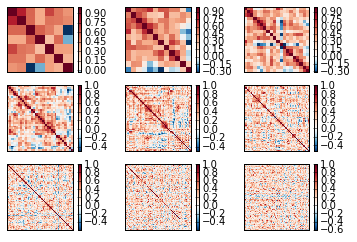

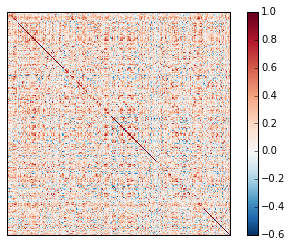

In [150]:
import matplotlib.gridspec as gridspec


grid1 = gridspec.GridSpec(3,3)
plt.figure()
for i in range(9):
    x = conn[i].loc[demograph.index.values].values
    ax2 = plt.subplot(grid1[i])
    
    visu.mat(ts.vec2mat(x[1,:]),show_axis=False)
    
    
plt.figure()

x = conn[8].loc[demograph.index.values].values

visu.mat(ts.vec2mat(x[1,:]),show_axis=False)

In [142]:
from sklearn.cross_validation import cross_val_score
n_components = np.arange(20, 40, 5)  # options for n_components

def compute_scores(X):
    pca = PCA()
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores

compute_scores(x_scaled)

([-1245.8414182738195,
  -1159.018789125221,
  -1080.1955410426428,
  -1006.479268276882],
 [292.52619669777658,
  191.2862560838295,
  52.310166766846145,
  -144.28353274501137])

In [83]:
a=np.array([0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
a.sum()/float(len(a))

0.5

# full model

iRelief ...
iRelief, sample size:  (116, 2016)
iRelief, sample size:  (116, 2016)
iRelief, sample size:  (116, 2016)
iRelief, sample size:  (116, 2016)
iRelief, sample size:  (117, 2016)
iRelief, sample size:  (117, 2016)
iRelief, sample size:  (118, 2016)
iRelief, sample size:  (118, 2016)
iRelief, sample size:  (118, 2016)
iRelief, sample size:  (118, 2016)
Running grid search ...
(146, 90)
Train: 0.838461538462
Test : 0.6875
Prediction : [0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1]
Real Labels: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
iRelief ...
iRelief, sample size:  (116, 2016)
iRelief, sample size:  (116, 2016)
iRelief, sample size:  (116, 2016)
iRelief, sample size:  (116, 2016)
iRelief, sample size:  (117, 2016)
iRelief, sample size:  (117, 2016)
iRelief, sample size:  (118, 2016)
iRelief, sample size:  (118, 2016)
iRelief, sample size:  (118, 2016)
iRelief, sample size:  (118, 2016)
Running grid search ...
(146, 90)
Train: 0.830769230769
Test : 0.75
Prediction : [0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 

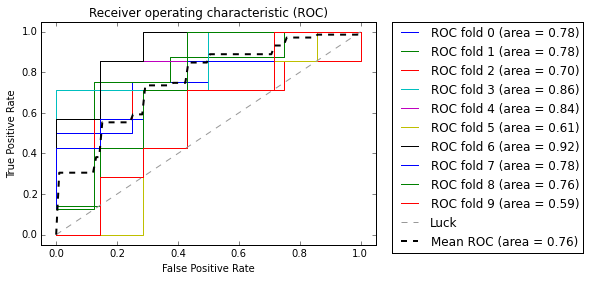

mean 6.7755952381  variance  0.0


In [39]:
#from sklearn.lda import LDA
from sklearn.metrics import roc_curve, auc
from Proteus.proteus.predic import predlib as plib
from scipy import interp
reload(fselect)
reload(plib)


skf = StratifiedKFold(y=encoder.transform(y), n_folds=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

total_test_score=0

for i, (train, test) in enumerate(skf):
    

    w = fselect.irelief_cross(x_scaled[train,:],encoder.transform(y[train]),10)
    candidat_f = fselect.nBest(w,90)
    if len(candidat_f)>0:
        select_x = x_scaled[:,candidat_f]
    else:
        select_x = x_scaled

    
    #print("%s %s" % (train, test))
    #print x_scaled[test]
    #print y[train], np.sum(y[train]==1),np.sum(y[train]==2)
    #print(clf.get_params)
    #clf = LDA()
    
    #C_range = 10.0 ** np.arange(-7,5)
    #gamma_range = 10.0 ** np.arange(-5, 3)
    #param_grid = dict(gamma=gamma_range, C=C_range)
    #cv = StratifiedKFold(y=encoder.transform(y), n_folds=10)
    #grid = GridSearchCV(SVC(kernel='rbf', class_weight='auto'), param_grid=param_grid, cv=cv)
    
    
    clf = SVC(kernel='linear', class_weight='auto')
    clf.probability = True
    clf, score = plib.grid_search(clf, select_x[train,:], encoder.transform(y[train]), n_folds=10, verbose=False)
    print select_x.shape
    
    #grid.fit(select_x[train,:], encoder.transform(y[train]))

    #print("The best classifier is: ", grid.best_estimator_)
    #param_grid
    #clf = grid.best_estimator_
    
    clf.probability = True
    clf.fit(select_x[train],encoder.transform(y[train]))
    print "Train:",clf.score(select_x[train,:],encoder.transform(y[train]))
    print "Test :",clf.score(select_x[test,:],encoder.transform(y[test]))
    print "Prediction :",clf.predict(select_x[test,:])
    print "Real Labels:",encoder.transform(y[test])
    
    total_test_score += clf.score(select_x[test,:],encoder.transform(y[test]))
    
    probas_ = clf.predict_proba(select_x[test,:])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

total_test_score
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#skf = cross_validation.StratifiedKFold(y, n_folds=10)
#bc.classif(x,y,20)
#prediction.basicconn(skf,x,y)

print 'mean', np.mean(total_test_score), ' variance ', np.std(total_test_score)*2


(130,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Running grid search ...


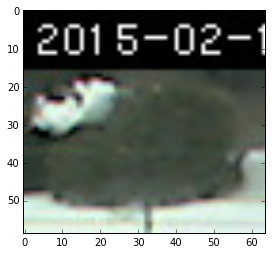

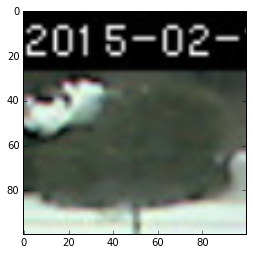

In [148]:
from PIL import Image
from skimage import io
from pylearn2.utils.rng import make_np_rng

import numpy
from scipy import misc


class Person():
    _default_seed = 2015 + 1 + 18
    def __init__(self,rng=_default_seed):
        self.scaled_size = 100
        self.crop_size = 100
        self.rng = make_np_rng(rng, which_method="random_integers")
    
    def preprocess(self, image):
            small_axis = numpy.argmin(image.shape[:-1])
            ratio = (1.0 * self.scaled_size) / image.shape[small_axis]
            resized_image = misc.imresize(image, ratio)
            axis_size = resized_image.shape[:-1]
            i=0
            j=0
            if axis_size[0] == self.scaled_size:
                if not axis_size[1] == self.scaled_size:
                    max_j = resized_image.shape[1] - self.crop_size
                    j = self.rng.randint(low=0, high=max_j)
                    i = 0
            elif axis_size[1] == self.scaled_size:
                if not axis_size[0] == self.scaled_size:
                    max_i = resized_image.shape[0] - self.crop_size
                    i = self.rng.randint(low=0, high=max_i)
                    j = 0

            # crop
            cropped_image = resized_image[i: i + self.crop_size,
                                          j: j + self.crop_size, :]
            return cropped_image

    
im = io.imread("/Users/christian/git/vision_or/set1/036.jpg")
im = im[0:59][:,0:64,:]
plt.figure()
plt.imshow(im)
p = Person()
im = p.preprocess(im)

plt.figure()
plt.imshow(im)

In [61]:
#conn[4].loc[demograph.index.values].values

reload(ts)
for i in range(0,len(conn)):
    
    print ts.vec2mat(conn[i].values[0,:]).shape



(7, 7)
(12, 12)
(20, 20)
(36, 36)
(64, 64)
(122, 122)
(197, 197)
(325, 325)
(444, 444)
